In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

#data augmentation
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
root_train = 'ants_and_bees/train'
root_val = 'ants_and_bees/val'

training_dataset = datasets.ImageFolder(root=root_train, transform=transform)
validation_dataset = datasets.ImageFolder(root=root_val, transform=transform)

In [2]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [3]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


classes of ants and bees

In [4]:
classes = ('ant', 'bee')

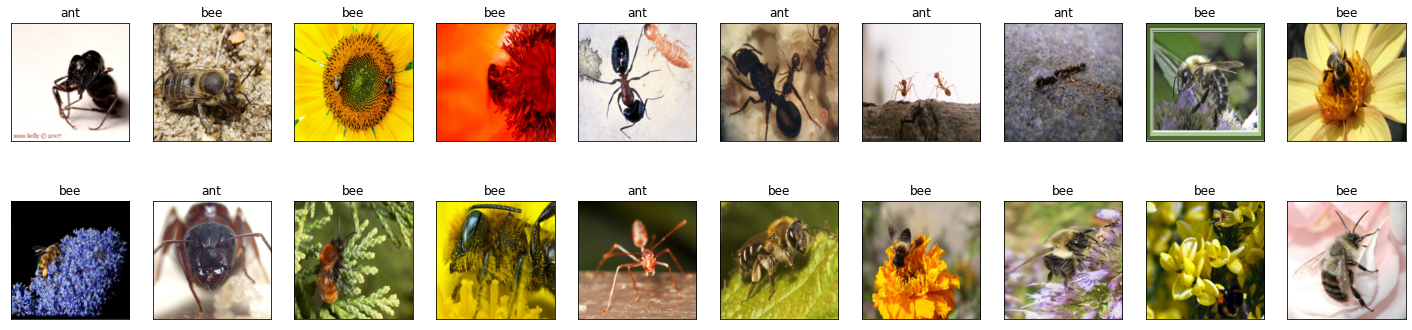

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,6))

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) #shape 32 x 32 x 1
  #de-normalisation - multiply by std and add mean
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  #print(labels[idx].item())
  ax.set_title(classes[labels[idx].item()])
plt.show()

Using pre-trained AlexNet

In [12]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Nianguo-PO/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
for param in model.features.parameters():
    param.requires_grad = False                     

import torch.nn as nn

n_inputs = model.classifier[6].in_features      #4096
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 5
losses = []
accuracy = []
val_losses = []
val_accuracies = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_loss = 0.0
  val_accuracy = 0.0

  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)   
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_accuracy += torch.sum(preds == labels.data)
    running_loss += loss.item() 

    #不必为验证集执行梯度
    with torch.no_grad():       
      for val_images, val_labels in validation_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy += torch.sum(val_preds == val_labels.data)
        val_loss += val_loss.item() 
    # metrics for training data
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_accuracy = running_accuracy.float()/len(training_loader.dataset)
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    # metrics for validation data
    val_epoch_loss = val_loss/len(validation_loader.dataset)
    val_epoch_accuracy = val_accuracy.float()/len(validation_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    #print the training and validation metrics
    print("epoch:", e+1)
    print('training loss: {:.6f}, acc {:.6f}'.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.6f}, acc {:.6f}'.format(val_epoch_loss, val_epoch_accuracy.item()))

C:\Users\Nianguo-PO\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1
training loss: 0.029282, acc 0.750000
validation loss: 0.003454, acc 0.875817
epoch: 2
training loss: 0.009381, acc 0.934426
validation loss: 0.004571, acc 0.856209
epoch: 3
training loss: 0.004004, acc 0.975410
validation loss: 0.007595, acc 0.862745
epoch: 4
training loss: 0.001639, acc 0.995902
validation loss: 0.007708, acc 0.908497
epoch: 5
training loss: 0.000799, acc 1.000000
validation loss: 0.008602, acc 0.895425


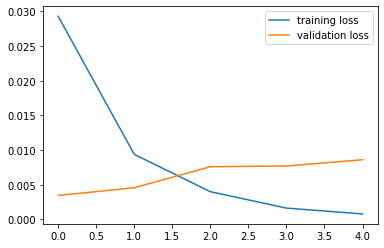

In [16]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

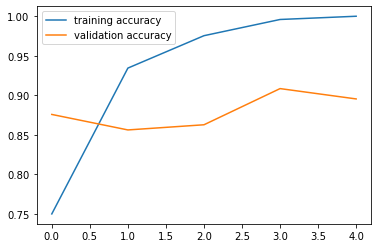

In [17]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

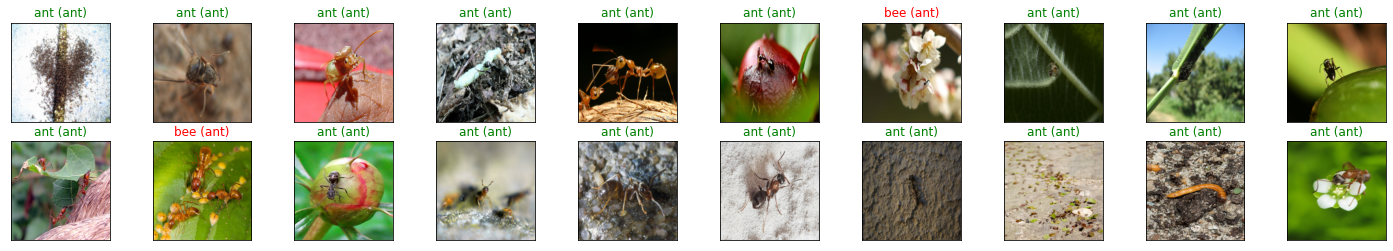

In [18]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()


